In [14]:
# Libraries
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [15]:
def load_test_data(file_path):
    # Opens file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Variables to keep track of the data
    data = []
    labels = []
    current_digit = 0
    current_block = []
    blocks_counter = 0

    for line in lines:
        # If the line is not blank
        if line.strip():
            # Get the first 9 coefficients
            coefficients = list(map(float, line.split()))[:9]
            current_block.append(coefficients)
        else:
            # If its the end of block
            if current_block:
                # Gets the average of the block
                avr_vector = np.mean(current_block, axis=0)
                data.append(avr_vector)
                labels.append(current_digit)

                # Reset the block
                current_block = []
                blocks_counter += 1

            # If its the last block of the digit
            if blocks_counter == 220:
                current_digit += 1
                blocks_counter = 0

    # Adds the last block
    if current_block:
        avr_vector = np.mean(current_block, axis=0)
        data.append(avr_vector)
        labels.append(current_digit)

    return data, labels

In [16]:
def load_training_data(file_path):
    # Opens file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Variables to keep track of the data
    data = []
    labels = []
    current_digit = 0
    current_block = []
    blocks_counter = 0

    for line in lines:
        # If the line is not blank
        if line.strip():
            # Get the first 9 coefficients
            coefficients = list(map(float, line.split()))[:9]
            current_block.append(coefficients)
        # If its the end of a block
        else:
            if current_block:
                # Gets the average of the block
                avr_vector = np.mean(current_block, axis=0)
                data.append(avr_vector)
                labels.append(current_digit)

                # Reset the block
                current_block = []
                blocks_counter += 1

            # If its the last block of the digit
            if blocks_counter == 660:
                current_digit += 1
                blocks_counter = 0

    # Adds the last block
    if current_block:
        data.extend(current_block)
        labels.extend([current_digit] * len(current_block))

    return np.array(data), np.array(labels)

In [17]:
# Function to train the GMM model
def train_gmm_model(data, labels, num_components):
    # Initialize a list to store the GMM models
    gmm_models = []

    # Train a GMM model for each digit
    for digit in range(10):
        # Get the data from the current digit
        digit_data = data[np.array(labels) == digit]

        # number of components per digit
        components = num_components[digit]

        # Train the GMM for the current digit
        model = GaussianMixture(n_components=components, random_state=0)
        model.fit(digit_data)

        # Store the trained model
        gmm_models.append(model)

    return gmm_models

In [18]:
# Function to calculate the log likelihood in a block
def get_block_likelihood(block, gmm):
    log_likelihoods = [gmm.score_samples([block])[0]]
    total_log_likelihood = np.sum(log_likelihoods)
    return total_log_likelihood

In [19]:
# Reads the data
file_path = './data/Train_Arabic_Digit.txt'
train_data, train_labels = load_training_data(file_path)

In [20]:
gmm_components = {0: 3, 1: 4, 2: 6, 3: 4, 4: 3, 5: 3, 6: 3, 7: 5, 8: 7, 9: 5}

In [21]:
# Train the GMM models
gmm_models = train_gmm_model(train_data, train_labels, gmm_components)

In [22]:
# Load the test data
test_file_path = './data/Test_Arabic_Digit.txt'
test_data, test_labels = load_test_data(test_file_path)

In [23]:
# Predict labels for each block in the test set
predicted_labels = []
for block in test_data:
    block_likelihoods = [get_block_likelihood(block, gmm) for gmm in gmm_models]
    predicted_digit = np.argmax(block_likelihoods)
    predicted_labels.append(predicted_digit)

In [24]:
# Calculate accuracy of the predictions
accuracy = np.mean(np.array(predicted_labels) == np.array(test_labels))
print(f'Overall Accuracy: {accuracy}')

Overall Accuracy: 0.6504545454545455


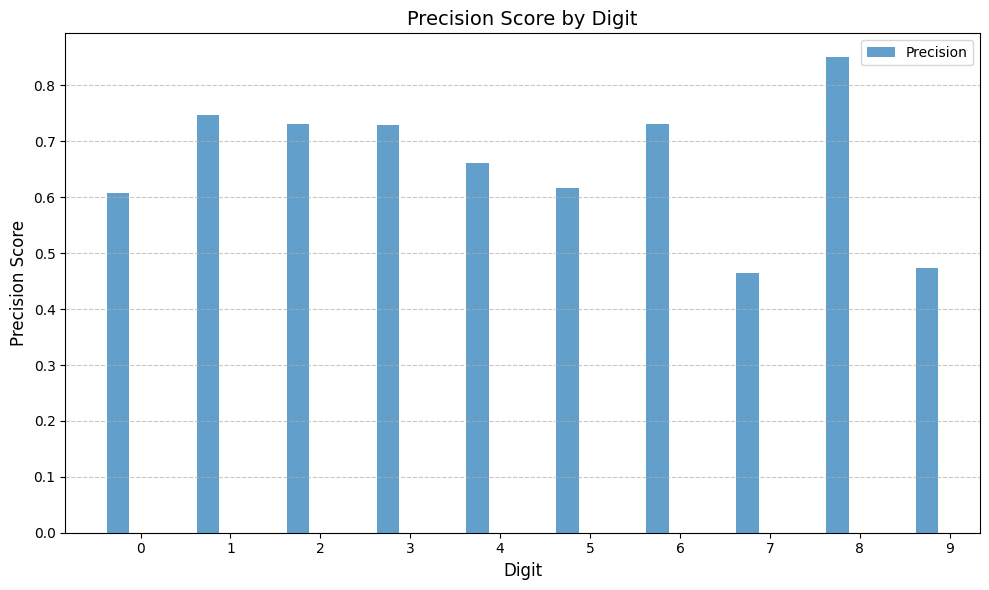

In [ ]:
# Calculate precision, recall, and F1-score for each digit
precision, recall, f1, _ = precision_recall_fscore_support(
    np.array(test_labels), 
    np.array(predicted_labels), 
    labels=np.arange(10)
)

# Bar chart for precision, recall, and F1-score
x = np.arange(10)  # Digits from 0 to 9
width = 0.25  # Width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric as grouped bars
ax.bar(x - width, precision, width, label='Precision', alpha=0.7)
ax.bar(x, recall, width, label='Recall', alpha=0.7)
ax.bar(x + width, f1, width, label='F1-Score', alpha=0.7)

# Add titles and labels
ax.set_title('Precision, Recall, and F1-Score by Digit', fontsize=14)
ax.set_xlabel('Digit', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([str(i) for i in range(10)])
ax.legend()

# Add a grid for clarity
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()